In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [47]:
def grafgen(M):
    U = [ "{}".format(int(i+1)) for i in range(M.shape[0]) ]
    G = nx.DiGraph()
    G.add_edges_from([ (U[i], U[j]) for i, j in zip(*M.nonzero()) ])
    pos = nx.spring_layout(G)
    plt.figure()    
    nx.draw(G, pos, edge_color = 'black', width = 1, linewidths =1 ,\
    node_size = 900, node_color = 'pink', alpha = 0.9,\
    labels = {node:node for node in G.nodes()})
    for i, j in zip(*M.nonzero()):
        #G.add_edge(U[i], U[j], weight=M[i][j], type="green")
        nx.draw_networkx_edge_labels(G,pos,edge_labels={(U[i], U[j]): str(M[i][j])}) 
    plt.axis('off')
    plt.show()

In [3]:
def graphIsFull(graph):
    fullGraph = np.ones((len(graph),len(graph))) - np.eye(len(graph))
    return np.array_equal(graph,fullGraph)

def p_zero(eigs):
    return len(np.where(eigs == 0)[0])

def p_neg(eigs):
    return len(np.where(eigs < 0)[0])

def p_pos(eigs):
    return len(np.where(eigs > 0)[0])

def chromaticNumberForFull(eigs):
    return len(eigs)/(p_zero(eigs) + min(p_neg(eigs),p_pos(eigs)))

In [4]:
def graphIsBipartite(eigs):
    res = True
    for x in eigs:
        res = (len(np.where(eigs == -x)[0]) != 0)
        if not res:
            return res
    return res

In [5]:
def graphIsRegular(eigs):
    r = round(sum(np.power(eigs, 2)), 7)
    return [round(r, 0) == r, r]

def graphIsRegularWithSpecificR(eigs):
    return 0 #TBD

In [27]:
def graphIsConnected(graph):
    graph = csr_matrix(graph)
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
    return n_components == 1

def p(x, eigs):
    return len(np.where(eigs == x))

def upperLimitForRegularAndConnected(eigs, r, n):
    return r + min(p(r - n, eigs), p(0, eigs) // (n - r - 1) + p(2, eigs) + p(-1, eigs) // -3) - (n - r) * p(r - n, eigs)

In [43]:
def upperLimitFromMax(eigs):
    return max(eigs) + 1

def upperLimitFromDims(graph):
    m = len(np.where(graph != 0)[0])
    return 1 + (2 * m * (1 - 1 / len(graph))) ** 0.5

def upperLimitFromEdges(graph):
    m = len(np.where(graph != 0)[0])
    return 0.5 + (2 * m + 0.25) ** 0.5

def lowerLimitFromMaxAndMin(eigs):
    return -1 * max(eigs) / min(eigs) + 1

def lowerLimitFromHellerLemma(graph):
    m = len(np.where(graph != 0)[0])
    n = len(graph)
    return n ** 2 / (n ** 2 - 2 * m)

def lowerLimitFromIndex(r, n):
    return n / (n - r)

In [17]:
def chromaticNumber(mat):
    eigenvals = np.linalg.eig(mat)[0]
    if graphIsFull(mat):
        return chromaticNumberForFull(eigenvals)
    
    if graphIsBipartite(eigenvals):
        return 2
    
    if graphIsRegular(eigenvals)[0]:
        if graphIsRegular(eigenvals)[1] == len(eigenvals) - 3:
            return graphIsRegularWithSpecificR(eigenvals)

In [10]:
#Take matrix size from first row input

firstRow = input().split(" ")
n = len(firstRow)

#initialise nxn matrix with zeroes
mat = np.zeros((n,n))

mat[0] = firstRow
#input each row at a time,with each element separated by a space
for i in range(1, n):
   mat[i] = input().split(" ")

print(mat) 

0 1 1 1
1 0 1 1
1 1 0 1
1 1 1 0
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


Given matrix has such eigenvalues and eigenvectors:

Eigenvalue:
-1.0
Eigenvector:
[-0.8660254   0.28867513  0.28867513  0.28867513]

Eigenvalue:
3.0
Eigenvector:
[0.5 0.5 0.5 0.5]

Eigenvalue:
-0.9999999999999998
Eigenvector:
[ 0.21699376 -0.86278187  0.32289406  0.32289406]

Eigenvalue:
-1.0
Eigenvector:
[ 0.          0.         -0.70710678  0.70710678]



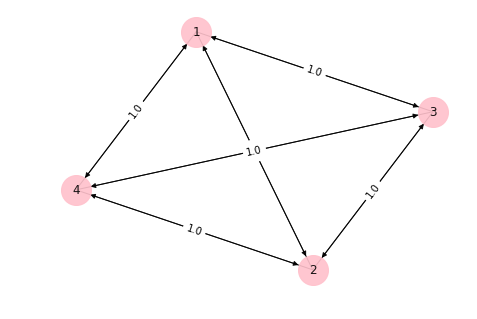

In [11]:
eigenvectors = np.zeros((len(np.linalg.eig(mat)[1]),len(np.linalg.eig(mat)[1])))
for i in range(len(np.linalg.eig(mat)[1])):   
    eigenvectors[i] = np.linalg.eig(mat)[1][:,i]
    
eigenvalues = np.linalg.eig(mat)[0]
print('\033[1m'+'Given matrix has such eigenvalues and eigenvectors:'+'\033[0m')
print()

for i in range(len(np.linalg.eig(mat)[0])):
    print ('\033[1m'+'Eigenvalue:'+'\033[0m')
    print(eigenvalues[i])
    print ('\033[1m'+'Eigenvector:'+'\033[0m')
    print(eigenvectors[i])
    print()
    
grafgen(mat)    

In [32]:
print('Exact Chromatic Number:')
print(chromaticNumber(mat))
print()

Exact Chromatic Number:
4.0



In [45]:
print('Upper Limit From Maximum Of Eigenvalues:')
print(upperLimitFromMax(eigenvalues))
print()

print('Upper Limit From Dimensions:')
print(upperLimitFromDims(mat))
print()

print('Lower Limit From Maximum And Minimum Of Eigenvalues:')
print(lowerLimitFromMaxAndMin(eigenvalues))
print()

print('Lower Limit From Heller Lemma:')
print(lowerLimitFromHellerLemma(mat))
print()

if graphIsConnected(mat):
    print('Upper Limit From Edges Quantity:')
    print(upperLimitFromEdges(mat))
    print()

if len(eigenvalues) - graphIsRegular(eigenvalues)[1] % 2 == 0 and graphIsConnected(mat):
    print('Upper Limit For Regular And Connected Graph With Odd n - r:')
    print(upperLimitForRegularAndConnected(eigenvalues, graphIsRegular(eigenvalues)[1], len(eigenvalues)))
    print()
    
if graphIsRegular(eigenvalues)[0]:
    print('Lower Limit From Regularity Index')
    print(lowerLimitFromIndex(graphIsRegular(eigenvalues)[1], len(mat)))
    print()

Upper Limit From Maximum Of Eigenvalues:
4.0

Upper Limit From Dimensions:
5.242640687119285

Lower Limit From Maximum And Minimum Of Eigenvalues:
4.0

Lower Limit From Heller Lemma:
-2.0

Upper Limit From Edges Quantaty:
5.424428900898052

Lower Limit From Regularity Index
-0.5

